# Revisar el cuaderno auxiliar 
Pegar aquí la url del git hub

In [2]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt

# ==========================
# 1) Cargar datos
# ==========================
data = pd.read_csv("respiralimpio_data_clean.csv")  # asegúrate que 'State' exista
data


,Vehicle type,Fuel type,Vehicle age,State
0,INDEPENDENT,BI-GNV,1,APPROVED
1,INDEPENDENT,BI-GNV,1,APPROVED
2,STATION,BI-GNV,5,DISAPPROVED
3,PRIVATE,BI-GNV,0,DISAPPROVED
4,INDEPENDENT,BI-GNV,1,APPROVED
...,...,...,...,...
1669,PRIVATE,GASOLINA,1,DISAPPROVED
1670,INDEPENDENT,GASOLINA,16,DISAPPROVED
1671,REMISSION,GNV,3,APPROVED
1672,INDEPENDENT,GASOLINA,25,DISAPPROVED


In [4]:
target = "State"
assert target in data.columns, f"'{target}' no está en las columnas: {list(data.columns)[:10]}..."

# Drop rows with missing target (if any)
data = data.dropna(subset=[target])


In [5]:

# 2) Split
X = data.drop(columns=[target])
y = data[target]

# Stratified split to preserve class proportions
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Matriz de Confusión (conteos)                    Pred: APPROVED  Pred: DISAPPROVED
Real: APPROVED                107                 53
Real: DISAPPROVED              60                115
              precision    recall  f1-score   support

    APPROVED     0.6407    0.6687    0.6544       160
 DISAPPROVED     0.6845    0.6571    0.6706       175

    accuracy                         0.6627       335
   macro avg     0.6626    0.6629    0.6625       335
weighted avg     0.6636    0.6627    0.6629       335



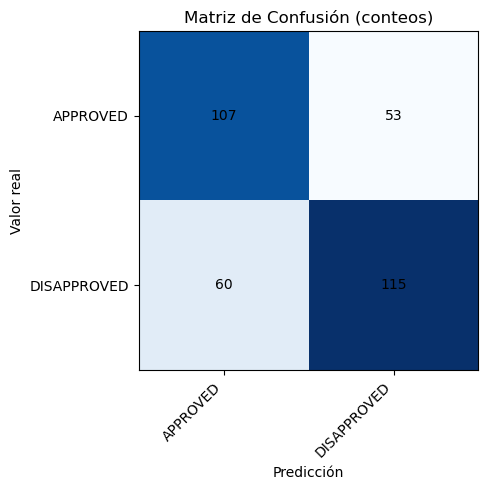

In [14]:

# 3) Preprocessing
cat_features = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
num_features = X_train.select_dtypes(include=["number"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features),
    ],
    remainder="drop",
)

# 4) Model (simple baseline)
model = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)

pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", model)
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

# 5) Confusion Matrix
labels = sorted(pd.unique(y_test))
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=[f"Real: {lbl}" for lbl in labels],
                        columns=[f"Pred: {lbl}" for lbl in labels])

# Normalized (row-wise)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
cm_norm = np.nan_to_num(cm_norm)


# Display dataframes to user
print("Matriz de Confusión (conteos)", cm_df)

# 6) Plot single confusion matrix figure (counts)
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm)  # default colormap; do not specify colors
# Use a light colormap
im = ax.imshow(cm, cmap="Blues")  # explicitly specifying a light-themed colormap

# ticks and labels
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_yticklabels(labels)
ax.set_xlabel("Predicción")
ax.set_ylabel("Valor real")
ax.set_title("Matriz de Confusión (conteos)")

# write counts in each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, str(cm[i, j]), ha="center", va="center")

plt.tight_layout()

# Save plot and CSVs
fig_path = "confusion_matrix.png"
csv_counts_path = "confusion_matrix_counts.csv"

plt.savefig(fig_path, dpi=150, bbox_inches="tight")
cm_df.to_csv(csv_counts_path, index=True)

# Classification report
report = classification_report(y_test, y_pred, digits=4, output_dict=False)
print(report)

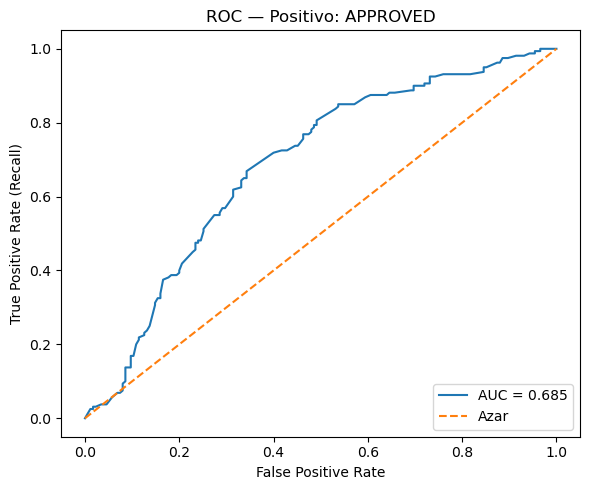

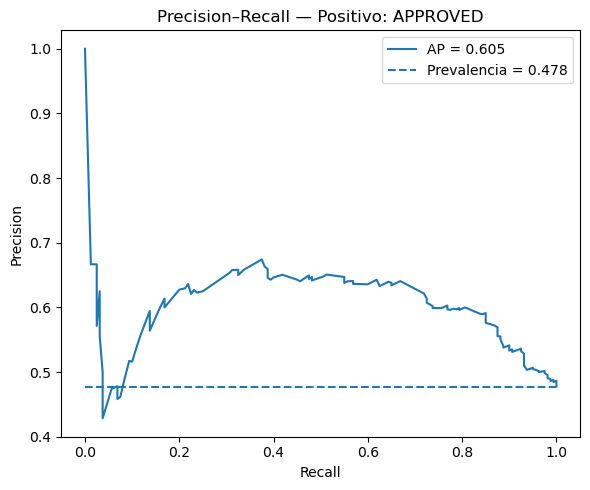

[BINARIO] AUC-ROC: 0.685 | AP (PR area): 0.605 | Prevalencia: 0.478


In [15]:
# ==========================
# ROC y PR (binario o multiclase, OvR)
# Requiere: pipe (ya entrenado), X_test, y_test
# ==========================
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    roc_curve, auc, roc_auc_score,
    precision_recall_curve, average_precision_score
)
import matplotlib.pyplot as plt

# 1) Obtener puntajes (probabilidades o decision_function)
model = pipe.named_steps["model"]
if hasattr(model, "predict_proba"):
    y_score = pipe.predict_proba(X_test)  # (n_samples, n_classes)
elif hasattr(model, "decision_function"):
    # SVMs, etc.
    scores = pipe.decision_function(X_test)
    # Asegurar forma 2D
    y_score = scores if scores.ndim > 1 else np.c_[1 - scores, scores]
else:
    raise ValueError("El modelo no expone predict_proba ni decision_function.")

classes = getattr(model, "classes_", np.unique(y_test))
classes = np.array(classes)
n_classes = len(classes)

# ==========================
# Caso BINARIO
# ==========================
if n_classes == 2:
    # Ajusta el positivo si quieres otro (ej: "APPROVED")
    pos_label = "APPROVED" if "APPROVED" in classes else classes[1]
    pos_idx = int(np.where(classes == pos_label)[0][0])
    y_scores_pos = y_score[:, pos_idx]

    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_scores_pos, pos_label=pos_label)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1],[0,1],"--", label="Azar")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title(f"ROC — Positivo: {pos_label}")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    # PR
    precision, recall, _ = precision_recall_curve(y_test, y_scores_pos, pos_label=pos_label)
    ap = average_precision_score(y_test, y_scores_pos, pos_label=pos_label)
    prevalence = float((y_test == pos_label).mean())

    plt.figure(figsize=(6,5))
    plt.plot(recall, precision, label=f"AP = {ap:.3f}")
    plt.hlines(prevalence, 0, 1, linestyles="--", label=f"Prevalencia = {prevalence:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision–Recall — Positivo: {pos_label}")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

    print(f"[BINARIO] AUC-ROC: {roc_auc:.3f} | AP (PR area): {ap:.3f} | Prevalencia: {prevalence:.3f}")

# ==========================
# Caso MULTICLASE (OvR)
# ==========================
else:
    # Binarizar y por clase
    y_bin = label_binarize(y_test, classes=classes)  # (n_samples, n_classes)

    # ROC por clase + micro
    plt.figure(figsize=(6,5))
    for i, c in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc_i = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Clase {c} (AUC={roc_auc_i:.3f})")
    # micro-average
    fpr_micro, tpr_micro, _ = roc_curve(y_bin.ravel(), y_score.ravel())
    auc_micro = auc(fpr_micro, tpr_micro)
    plt.plot(fpr_micro, tpr_micro, linestyle="--", label=f"Micro (AUC={auc_micro:.3f})")

    plt.plot([0,1],[0,1],"--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title("ROC OvR (multiclase)")
    plt.legend(loc="lower right", ncols=1)
    plt.tight_layout()
    plt.show()

    # PR por clase + micro
    plt.figure(figsize=(6,5))
    aps = []
    for i, c in enumerate(classes):
        prec, rec, _ = precision_recall_curve(y_bin[:, i], y_score[:, i])
        ap_i = average_precision_score(y_bin[:, i], y_score[:, i])
        aps.append(ap_i)
        plt.plot(rec, prec, label=f"Clase {c} (AP={ap_i:.3f})")
    # micro-average
    prec_micro, rec_micro, _ = precision_recall_curve(y_bin.ravel(), y_score.ravel())
    ap_micro = average_precision_score(y_bin, y_score, average="micro")
    plt.plot(rec_micro, prec_micro, linestyle="--", label=f"Micro (AP={ap_micro:.3f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall OvR (multiclase)")
    plt.legend(loc="upper right", ncols=1)
    plt.tight_layout()
    plt.show()

    # Resumen numérico (macro/micro/weighted)
    auc_macro = roc_auc_score(y_bin, y_score, average="macro", multi_class="ovr")
    auc_weighted = roc_auc_score(y_bin, y_score, average="weighted", multi_class="ovr")
    ap_macro = average_precision_score(y_bin, y_score, average="macro")
    ap_weighted = average_precision_score(y_bin, y_score, average="weighted")

    print(f"[MULTICLASE] AUC-ROC macro: {auc_macro:.3f} | weighted: {auc_weighted:.3f} | micro: {auc_micro:.3f}")
    print(f"[MULTICLASE] AP (PR)  macro: {ap_macro:.3f} | weighted: {ap_weighted:.3f} | micro: {ap_micro:.3f}")


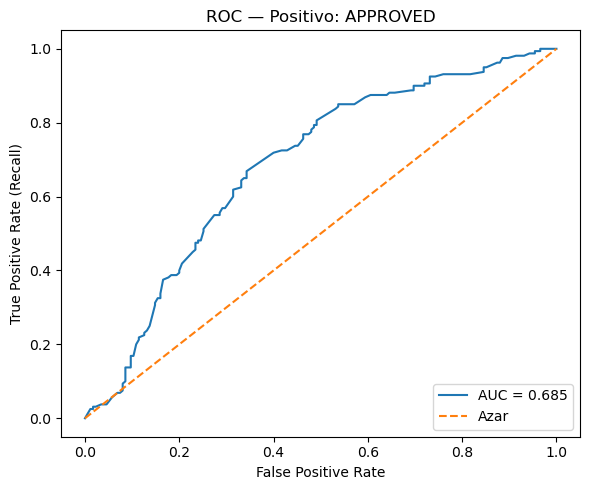

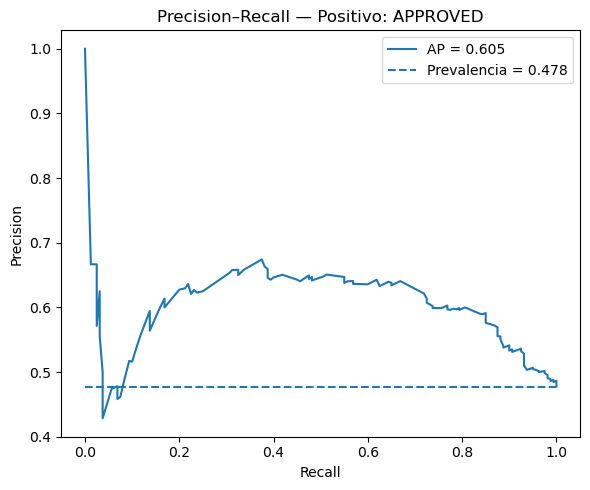

[APPROVED] AUC-ROC: 0.685 | AP: 0.605 | Prevalencia: 0.478


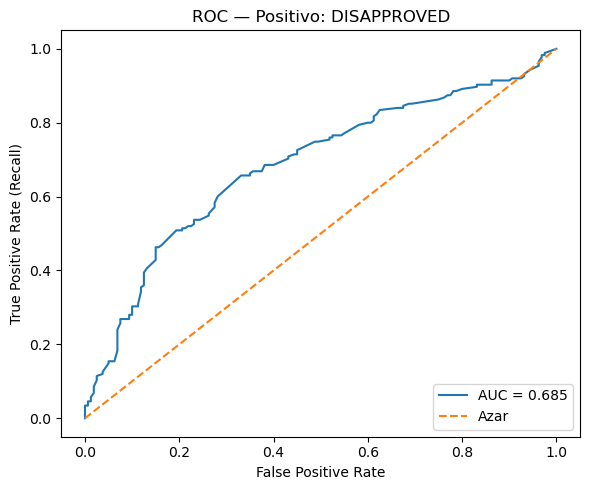

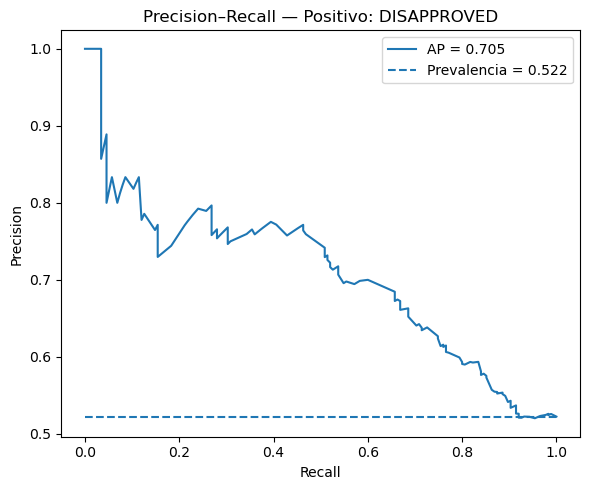

[DISAPPROVED] AUC-ROC: 0.685 | AP: 0.705 | Prevalencia: 0.522


In [16]:
# ==========================
# ROC y PR para ambas clases (binario)
# Requiere: pipe entrenado, X_test, y_test
# ==========================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

def roc_pr_for_class(pipe, X_test, y_test, pos_label):
    model = pipe.named_steps["model"]
    classes = model.classes_
    assert pos_label in classes, f"{pos_label} no está en {classes}"
    pos_idx = int(np.where(classes == pos_label)[0][0])
    y_score = pipe.predict_proba(X_test)[:, pos_idx]
    prevalence = float((y_test == pos_label).mean())

    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=pos_label)
    auc_roc = auc(fpr, tpr)

    # PR
    prec, rec, _ = precision_recall_curve(y_test, y_score, pos_label=pos_label)
    ap = average_precision_score(y_test, y_score, pos_label=pos_label)

    # Graficar ROC
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_roc:.3f}")
    plt.plot([0,1],[0,1],"--", label="Azar")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title(f"ROC — Positivo: {pos_label}")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    # Graficar PR
    plt.figure(figsize=(6,5))
    plt.plot(rec, prec, label=f"AP = {ap:.3f}")
    plt.hlines(prevalence, 0, 1, linestyles="--", label=f"Prevalencia = {prevalence:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision–Recall — Positivo: {pos_label}")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

    print(f"[{pos_label}] AUC-ROC: {auc_roc:.3f} | AP: {ap:.3f} | Prevalencia: {prevalence:.3f}")

# Ejecutar para ambas clases:
for lbl in pipe.named_steps["model"].classes_:
    roc_pr_for_class(pipe, X_test, y_test, pos_label=lbl)


# Interpretación de métricas con `respiralimpio_data_clean.csv` (target = `State`)

> Configuración: modelo **RandomForest** con preprocesamiento (OHE + StandardScaler). Positivo para las curvas: **`APPROVED`**.  
> Conjunto de prueba ≈ 20% del dataset.

---

## 1) Matriz de Confusión (binario)

| Real \ Predicho | **APPROVED** | **DISAPPROVED** |
|---|---:|---:|
| **APPROVED**      | **TP = 107** | **FN = 53**  |
| **DISAPPROVED**   | **FP = 60**  | **TN = 115** |

- **Precision(APPROVED)** = `TP / (TP + FP)` = 107 / (107 + 60) ≈ **0.641**  
- **Recall(APPROVED)**    = `TP / (TP + FN)` = 107 / (107 + 53) ≈ **0.669**  
- **FPR**                 = `FP / (FP + TN)` = 60 / (60 + 115) ≈ **0.343**  
- **Accuracy global** ≈ **0.663**

> Lectura: a umbral ~0.5, el modelo recupera ~66.9% de los aprobados reales y, de lo que aprueba, ~64.1% son realmente aprobados.

---

## 2) Curva ROC (Receiver Operating Characteristic)

- **AUC-ROC ≈ 0.685** → **discriminación moderada** (0.5 = azar, 1.0 = perfecto).  
- Probabilística: hay ~**68.5%** de chance de asignar mayor score a un caso **APPROVED** que a uno **DISAPPROVED** tomado al azar.  
- Intercambio (trade-off): si subes el umbral ↓FPR pero también ↓Recall; si bajas el umbral ↑Recall pero ↑FPR.

> Nota: en binario, si cambias la clase positiva a `DISAPPROVED`, el **AUC-ROC numéricamente no cambia**.

---

## 3) Curvas Precision–Recall (PR)

**Por clase (One-vs-Rest):**

| Clase          | AP (área PR) | Prevalencia |
|----------------|:------------:|:-----------:|
| `APPROVED`     | **0.605**    | **0.478**   |
| `DISAPPROVED`  | **0.705**    | **0.522**   |

- Estar **por encima** de la línea de **prevalencia** indica valor sobre el azar dado el desbalance.  
- **`DISAPPROVED`** muestra **mejor separación** (AP=0.705) que `APPROVED` (AP=0.605).

**Métricas por clase (umbral ~0.5):**

| Clase          | Precision | Recall | F1   | Soporte |
|----------------|:---------:|:------:|:----:|:-------:|
| `APPROVED`     | **0.641** | 0.669  | 0.654|   160   |
| `DISAPPROVED`  | **0.685** | 0.657  | 0.671|   175   |

> Conclusión PR: **el modelo rinde mejor para `DISAPPROVED`** (AP y F1 mayores; precision mayor), aunque su recall es ligeramente menor que el de `APPROVED`.

---

## 4) Trade-off del umbral (threshold)

- **Subir** umbral ⇒ **↑ Precision**, **↓ Recall**, **↓ FPR** (apruebas menos, cometes menos falsos aprobados).  
- **Bajar** umbral ⇒ **↓ Precision**, **↑ Recall**, **↑ FPR** (recuperas más aprobados reales, pero se cuelan más falsos).  

**Criterios para elegir umbral:**
1. **Máximo F1** → equilibrio general entre Precision y Recall.  
2. **Precision mínima** (p.ej., ≥ 0.75) → prioriza **reducir FP** (menos falsos aprobados).  
3. **Recall mínimo** (p.ej., ≥ 0.85) → prioriza **no perder positivos** (menos falsos rechazados).  
4. **Umbral por costos**  
   \[
   t^\*=\frac{C_{FP}}{C_{FP}+C_{FN}}
   \]
   con \(C_{FP}\)= costo de un falso **aprobado** y \(C_{FN}\)= costo de un falso **rechazado**.

---

## 5) Recomendaciones didácticas

- Mostrar **cómo cambia la matriz de confusión** cuando se mueve el umbral (p.ej., máximo F1 vs. precision objetivo).  
- Comparar **ROC vs. PR**: en desbalance, **PR** suele ser más informativa.  
- Incluir **calibración de probabilidades** (Platt/Isotónica) antes de fijar umbrales por costo.  
- Probar **modelos de boosting** (XGBoost/LightGBM) y **nuevas variables** para mejorar AUC y AP.

---


# Para la guía autónoma
realizar los mismo pero con tus datos en caso que tu objetivo de tu proyecto grupal sea de clasificación, sino busca otros datos

NOTA: Debes anexar el cuaderno auxiliar